In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _tconfint_generic
from scipy import stats
from scipy.stats import norm

## Доверительные интервалы

### 1-й тест

In [2]:
df = pd.read_csv('water.txt', sep='\t')

In [3]:
df.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


In [4]:
df['mortality'].std(ddof=1)

187.6687539314571

In [25]:
_tconfint_generic(df['mortality'].mean(), df['mortality'].std(ddof=1)/np.sqrt(len(df['mortality'])), 
                 len(df['mortality'])-1, 0.05, 'two-sided')

(1476.0833413552848, 1572.2117406119285)

In [42]:
df_south_mort = df.loc[df['location']=='South','mortality']
_tconfint_generic(df_south_mort.mean(), df_south_mort.std(ddof=1)/np.sqrt(len(df_south_mort)), 
                 len(df_south_mort)-1, 0.05, 'two-sided')

(1320.1517462936238, 1433.463638321761)

In [44]:
df_north_mort = df.loc[df['location']=='North','mortality']
_tconfint_generic(df_north_mort.mean(), df_north_mort.std(ddof=1)/np.sqrt(len(df_north_mort)), 
                 len(df_north_mort)-1, 0.05, 'two-sided')

(1586.5605251961385, 1680.6394748038613)

In [95]:
def get_t_conf_inf(data, alpha, alternative, *arr):
    if len(arr) == 0:
        return _tconfint_generic(data['mortality'].mean(),
                                 data['mortality'].std(ddof=1)/np.sqrt(len(data['mortality'])), 
                                 len(data['mortality'])-1, alpha, alternative)
    else:
        data = data.loc[df['location']==arr[0],arr[1]]
        return _tconfint_generic(data.mean(), data.std(ddof=1)/np.sqrt(len(data)), 
                 len(data)-1, alpha, alternative)

In [96]:
get_t_conf_inf(df, 0.05, 'two-sided')

(1476.0833413552848, 1572.2117406119285)

In [97]:
get_t_conf_inf(df, 0.05, 'two-sided', 'South', 'mortality')

(1320.1517462936238, 1433.463638321761)

In [98]:
get_t_conf_inf(df, 0.05, 'two-sided', 'North', 'mortality')

(1586.5605251961385, 1680.6394748038613)

In [99]:
get_t_conf_inf(df, 0.05, 'two-sided', 'South', 'hardness')

(53.467198692036106, 86.07126284642544)

In [100]:
get_t_conf_inf(df, 0.05, 'two-sided', 'North', 'hardness')

(21.42248728572426, 39.37751271427574)

In [9]:
np.ceil((norm.ppf(1-0.05/2)/0.1) ** 2)

385.0

### 2-й тест

In [14]:
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import samplesize_confint_proportion
import matplotlib.pyplot as plt

In [16]:
p = 1/50
alpha = 0.05
z = norm.ppf(1-alpha/2)
proportion_confint(1, 50, alpha=0.05, method='normal'), \
proportion_confint(1, 50, alpha=0.05, method='wilson')

((0.0, 0.05880530708179099), (0.003539259271646236, 0.10495443589637815))

In [112]:
#так как библиотечный интервал выдает нижнюю границу 0, кажется, что это не совсем верный ответ
#в ответе на курсере используется то же решение, но засчитывается именно отрицательный вариант левой границы
#возможно, что это некая его оптимизация, но если руками писать, то выдает то, что и ожидаемо
#так же если выбирать на курсере ответ "нормальное" вместо "уи"
p-z*np.sqrt(p*(1-p)/50)

-0.018805307081790974

In [140]:
np.ceil(samplesize_confint_proportion(1/50, 0.01, alpha=0.05, method='normal'))

753.0

In [127]:
def samplesize(p, half_width=0.01, alpha=0.05, method='normal'):
    return np.ceil(samplesize_confint_proportion(p, half_width, alpha, method))

In [132]:
p_arr = np.linspace(0.01, 1, 100)
g = np.vectorize(samplesize)
sample_sizes = g(p_arr)

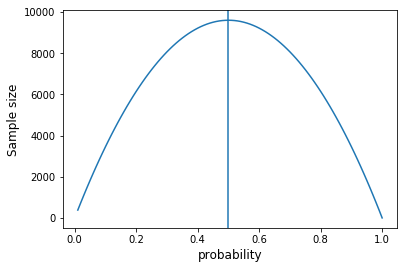

In [135]:
plt.plot(p_arr, sample_sizes)
plt.xlabel('probability', fontsize=12)
plt.ylabel('Sample size', fontsize=12)
plt.axvline(x=0.5)
plt.show()

In [136]:
dict(zip(p_arr, sample_sizes))[0.5]

9604.0

In [138]:
np.ceil(samplesize_confint_proportion(0.5, 0.01, alpha=0.05, method='normal'))

9604.0

### 3-й тест

In [2]:
norm.ppf(1-(1-0.997)/2)

2.9677379253417717

In [3]:
189/11034 - 104/11037

0.0077060239760047815

In [4]:
def conf_int_diff_part(p1, p2, n1, n2, alpha=0.05):
    z = norm.ppf(1-0.05/2)
    if p1 < p2:
        p1, p2 = p2, p1
        n1, n2 = n2, n1
    lower = p1 - p2 - z * np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    upper = p1 - p2 + z * np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    return lower, upper

In [5]:
conf_int_diff_part(189/11034, 104/11037, 11034, 11037)

(0.004687750675049439, 0.010724297276960124)

In [6]:
#отношение шансов
(189/11034/(1-189/11034)) / (104/11037/(1-104/11037))

1.8320539419087138

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices]
def stat_intervals(stat, alpha=0.05):
    return np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

In [15]:
data_asp = np.hstack((np.ones((104)),np.zeros((11037-104))))
data_plaz = np.hstack((np.ones((189)),np.zeros((11034-189))))

In [18]:
np.random.seed(0)
odds_asp = list(map(lambda arr: arr.mean()/(1-arr.mean()), get_bootstrap_samples(data_asp, 1000)))
odds_plaz = list(map(lambda arr: arr.mean()/(1-arr.mean()), get_bootstrap_samples(data_plaz, 1000)))

In [25]:
stat_intervals(np.array(odds_plaz) / np.array(odds_asp), 0.05)

array([1.44419465, 2.34321168])

## Проверка гипотез

In [28]:
stats.binom_test(67,100,0.75,'two-sided')

0.08222258891386608

In [29]:
stats.binom_test(22,50,0.75,'two-sided')

3.4831478978300243e-06

In [30]:
data = pd.read_csv('pines.txt', sep='\t')
data_binned = stats.binned_statistic_2d(data.sn, data.we, values=None, statistic='count', bins=[5,5])

In [35]:
data_binned.statistic.sum()/(data_binned.statistic.shape[0]*data_binned.statistic.shape[1])

23.36

In [36]:
val = data_binned.statistic.reshape(1,-1).ravel()
stats.chisquare(val,ddof=0)

Power_divergenceResult(statistic=150.58904109589042, pvalue=2.574669774967279e-20)